In [8]:
# Import Data
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import mplcursors
import numpy as np 
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator
from matplotlib.ticker import FuncFormatter
bond_price = pd.read_csv("data/BondPrice.csv")
bond_quant = pd.read_csv("data/BondQuant.csv") 

In [9]:
# reformat dataframe to create separate timestamp and price columns 
# drop NaN columns 
def melt_clean_price(df):
    # Drop columns with NaN 
    clean_df = df.dropna(axis=1) 
    df_melted = clean_df.melt(var_name='Timestamp', value_name='Price')
    df_melted = df_melted.iloc[2:].reset_index(drop=True)
    return df_melted

# Graph for price function
def graph_price(df, title):
    # convert timestamp dtype into datetime dtype
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    # Set up Seaborn plot
    fig, ax = plt.subplots(figsize=(10, 6))
    scatplot = sns.scatterplot(data=df, x='Timestamp', y='Price', marker='o')
    #scatplot.axvspan(xmin=pd.Timestamp("1819"), xmax=pd.Timestamp("1822"), fc="#E0837F")
    # Format x-axis ticks to show year 
    date_form = DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.gca().xaxis.set_major_locator(YearLocator())
    # Get the minimum and maximum dates with data (assuming 'date' is a datetime type)
    min_date = df['Timestamp'].min()
    max_date = df['Timestamp'].max()
    # Set the x-axis limits to exclude extra years
    plt.xlim(min_date, max_date)

    # Enhance plot aesthetics (optional)
    plt.xlabel('Year')
    plt.ylabel('Market Price (Dollars)')
    plt.title(title)
    plt.grid(True)

    # Add hovering features 
    def show_hover_panel(get_text_func=None):
        cursor = mplcursors.cursor(
            scatplot, 
            hover=2,  # Transient
            annotation_kwargs=dict(
                bbox=dict(
                    boxstyle="square,pad=0.5",
                    facecolor="white",
                    edgecolor="#ddd",
                    linewidth=0.5,
                    path_effects=[pe.withSimplePatchShadow(offset=(1.5, -1.5))],
                ),
                linespacing=1.5,
                arrowprops=None,
            ),
            highlight=True,
            highlight_kwargs=dict(linewidth=2),
        )
    
        if get_text_func:
            cursor.connect(
                event="add",
                func=lambda sel: sel.annotation.set_text(get_text_func(df, sel.index)),
            )
    
        return cursor
    
    
    def on_add(df, index):
        item = df.iloc[index]
        parts = [
            f"Date: {item.Timestamp.strftime('%Y-%m-%d')}",
            f"Price: {item.Price:,.2f}",
        ]
    
        return "\n".join(parts)

    show_hover_panel(on_add) # add cursor hover features 

    plt.plot(df['Timestamp'], df['Price'])
    
    return plt # return completed figure 

In [10]:
# clean quant dataframe 
# returns a series with chosen row 
def clean_quant(quant_df):
    subset_cols = quant_df.columns[2:] 
    # Drop rows where all columns are Nan 
    temp_clean_quant_df = quant_df.dropna(how="all", subset=subset_cols).dropna(axis=1)
    # print(clean_six_percent_prices)
    # print(temp_clean_six_percent_quant)
    
    # Define the threshold
    threshold = 0.001
    # Function to check if all values in a column are close to zero
    def is_close_to_zero(col, threshold):
        return np.all(np.abs(col) < threshold)
    
    cols_to_drop = [col for col in temp_clean_quant_df.iloc[:, 2:].columns if is_close_to_zero(temp_clean_quant_df[col], threshold)]
    
    # Drop the columns
    clean_quant_df = temp_clean_quant_df.drop(columns=cols_to_drop)
    return clean_quant_df
    # print(clean_quant_df) 

def reformat_quant(clean_quant_df, row):
    # reformat dataframe to include timestamp and quant columns 
    series_data = clean_quant_df[clean_quant_df["Series"] == row].melt(var_name='Timestamp', value_name='Quant')
    series_data = series_data.iloc[2:].reset_index(drop=True)
    series_data['Timestamp'] = pd.to_datetime(series_data['Timestamp']) #convert timestamp column to a datetime object 
    return series_data # return the selected row 

# graphing function
def graph_quant(df, title, axis):
    # Set up Seaborn plot
    fig, ax = plt.subplots(figsize=(10, 6))
    # lineplot = sns.lineplot(data=df, x="Timestamp", y="Quant") 
    scatplot = sns.scatterplot(data=df, x='Timestamp', y='Quant', marker='o')
    #scatplot.axvspan(xmin=pd.Timestamp("1819"), xmax=pd.Timestamp("1822"), fc="#E0837F")
    # Format x-axis ticks to show year 
    date_form = DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.gca().xaxis.set_major_locator(YearLocator(2))
    # Get the minimum and maximum dates with data (assuming 'date' is a datetime type)
    min_date = df['Timestamp'].min()
    max_date = df['Timestamp'].max()
    # Set the x-axis limits to exclude extra years
    plt.xlim(min_date, max_date)

    # reformat y-axis to be in millions, not tens of millions
    if axis == "mil":
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x / 1e6)))
        plt.ylabel('Total Outstanding (millions)')
    elif axis == "ht": 
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x / 1e5)))
        plt.ylabel('Total Outstanding (hundred thousands)')

    # Enhance plot aesthetics (optional)
    plt.xlabel('Year')
    plt.title(title)
    plt.grid(True)

        # Add hovering features 
    def show_hover_panel(get_text_func=None):
        cursor = mplcursors.cursor(
            scatplot, 
            hover=2,  # Transient
            annotation_kwargs=dict(
                bbox=dict(
                    boxstyle="square,pad=0.5",
                    facecolor="white",
                    edgecolor="#ddd",
                    linewidth=0.5,
                    path_effects=[pe.withSimplePatchShadow(offset=(1.5, -1.5))],
                ),
                linespacing=1.5,
                arrowprops=None,
            ),
            highlight=True,
            highlight_kwargs=dict(linewidth=2),
        )
    
        if get_text_func:
            cursor.connect(
                event="add",
                func=lambda sel: sel.annotation.set_text(get_text_func(df, sel.index)),
            )
    
        return cursor
    
    
    def on_add(df, index):
        item = df.iloc[index]
        parts = [
            f"Date: {item.Timestamp.strftime('%Y-%m-%d')}",
            f"Quant: {item.Quant:,.2f}",
        ]
    
        return "\n".join(parts)

    show_hover_panel(on_add) # add cursor hover features 
    
    plt.plot(df['Timestamp'], df['Quant'])
    return plt

# Add a historical marker
# An important event 
def add_marker(axis, event_str, date, price):
    axis.annotate(event_str,
            xy=(pd.Timestamp(date), price), xycoords='data',
            xytext=(30, 10), textcoords='offset points', size=8, 
            arrowprops=dict(facecolor='black', shrink=0.05))

# color background to define a period
def add_period(plot, begin, end):
    # ax.text(pd.Timestamp("1820-06"), 90, 'Panic of 1819', horizontalalignment='center')
    plot.axvspan(xmin=pd.Timestamp(begin), xmax=pd.Timestamp(end), fc="#E0837F")

## Six Percent Loan of 1812

### Overview and Features
1. Authorized By: <i>Act of March 14, 1812</i> (three months before war)
2. President can borrow <b>no more</b> than \$ 11 million.
3. Interest Rate: 6% 
4. Payment Frequency: Quarterly
5. 12-year loan (reimbursable on January 1, 1825)
6. Final Redemption: March 12, 1833 
7. Buyers could not sell stock certificates below par value.
8. The Treasury obtained <b>\$ 8,134,700</b> through issuing these stock certificates.
9. Temporary loan of $2,150,000 obtained under special contracts with various banks.
10. These loans, totaling <b>\$ 10,284,700</b> (8,134,700 + 2,150,000), have been completely repaid. 

### Marketing 
1. Overview: Banks and individuals were not interested in buying government debt 
2. Unimpressive: The modest interest rate (6%) did not excite many buyers.
3. The war question: Potential buyers did not buy because they were nervous that the United States could suffer defeat against Britain (the largest army and navy).
4. Lack of a market: Primarily regional securities markets
5. Lack of capability: American firms could not underwrite large securities issues, and American agents in Europe could not underwrite American securities issues.
6. The "solution": Due to the lack of capability, the Treasury announced the bonds and simply waited for investors to come.  
7. Consequences: Due to the lack of subscribers, Congress issued \$5 million worth of treasury notes (Treasury Notes of 1812).

### Who Bought Them? 
1. \$4.2 million bought by banks for their long-term portfolios.
2. \$2.0 million bought by individuals.
3. Attempts at better marketing: Gallatin (Treasury Secretary) wanted to increase interest rates from 6% and sell bonds at a discount; the proposal was rejected by Madison.
4. Reasons for failure: New Englanders remained unsympathetic to the war. Congress did not find a way to fulfill interest payments. 

#### Sources
- Dissertation (147)
- American Public Finance and Financial Services (328-330) 

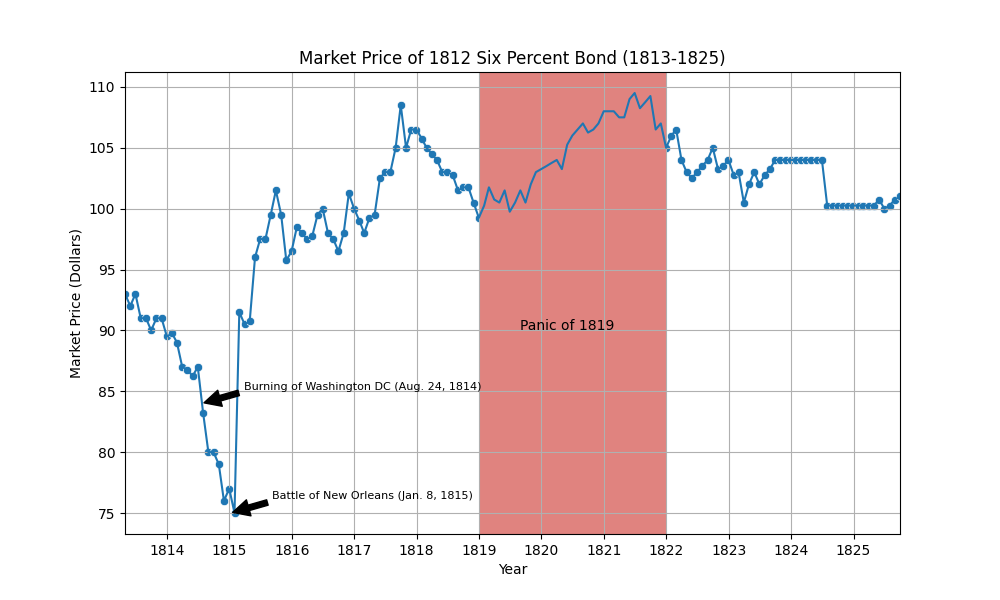

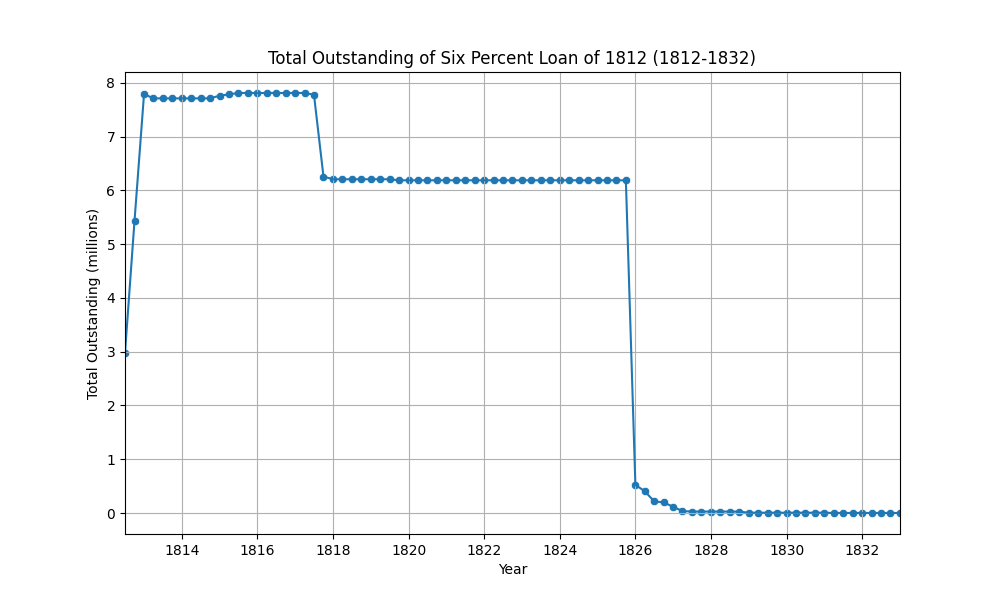

True


'\nax.annotate(\'Burning of Washington DC (Aug. 24, 1814)\',\n            xy=(pd.Timestamp("1814-7-24"), 84), xycoords=\'data\',\n            xytext=(30, 10), textcoords=\'offset points\',\n            arrowprops=dict(facecolor=\'black\', shrink=0.05))\n\nax.annotate(\'Battle of New Orleans (Jan. 8, 1815)\',\n            xy=(pd.Timestamp("1815-1-08"), 75), xycoords=\'data\',\n            xytext=(30, 10), textcoords=\'offset points\',\n            arrowprops=dict(facecolor=\'black\', shrink=0.05))\n'

In [11]:
# Six percent loan of 1812 
# prices 
six_percent_prices = bond_price[bond_price["L1 ID"] == 20048] 
six_percent_prices_melted = melt_clean_price(six_percent_prices) # clean and melt (reformat) dataframe 
six_percent_plot = graph_price(six_percent_prices_melted, 'Market Price of 1812 Six Percent Bond (1813-1825)')

# historical annotations 
add_marker(six_percent_plot, 'Burning of Washington DC (Aug. 24, 1814)', "1814-7-24", 84)
add_marker(six_percent_plot, 'Battle of New Orleans (Jan. 8, 1815)', "1815-1-08", 75) 
# Panic of 1819 
add_period(six_percent_plot, "1819", "1822")
six_percent_plot.text(pd.Timestamp("1820-06"), 90, 'Panic of 1819', horizontalalignment='center')

six_percent_plot.show()

# quantities 
six_percent_quant = bond_quant[bond_quant["L1 ID"] == 20048]
clean_six_percent_quant = clean_quant(six_percent_quant)
#print(clean_six_percent_quant) 
total_outstanding = reformat_quant(clean_six_percent_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Six Percent Loan of 1812 (1812-1832)", "mil") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_six_percent_quant, "Public Holdings")
#public_holdings.show()
print(public_holdings.equals(total_outstanding))

"""
ax.annotate('Burning of Washington DC (Aug. 24, 1814)',
            xy=(pd.Timestamp("1814-7-24"), 84), xycoords='data',
            xytext=(30, 10), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.annotate('Battle of New Orleans (Jan. 8, 1815)',
            xy=(pd.Timestamp("1815-1-08"), 75), xycoords='data',
            xytext=(30, 10), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05))
""" 

## Temporary Loan of 1812

### Overview and Features
### Marketing
### Who Bought Them?
#### Sources 

     L1 ID              Series  1812-06-30  1812-09-30  1812-12-31  \
238  20048  Active Outstanding   2977912.5   5434712.5   7792000.0   
241  20048     Public Holdings   2977912.5   5434712.5   7792000.0   
242  20048   Total Outstanding   2977912.5   5434712.5   7792000.0   

     1813-03-31  1813-06-30  1813-09-30  1813-12-31  1814-03-31  ...  \
238   7710500.0   7710500.0   7710500.0   7710500.0   7710500.0  ...   
241   7710500.0   7710500.0   7710500.0   7710500.0   7710500.0  ...   
242   7710500.0   7710500.0   7710500.0   7710500.0   7710500.0  ...   

     1830-09-30  1830-12-31  1831-03-31  1831-06-30  1831-09-30  1831-12-31  \
238      5500.0      5500.0       500.0       500.0       500.0       500.0   
241      5500.0      5500.0       500.0       500.0       500.0       500.0   
242      5500.0      5500.0       500.0       500.0       500.0       500.0   

     1832-03-31  1832-06-30  1832-09-30  1832-12-31  
238       500.0       500.0       500.0       500.0  
241  

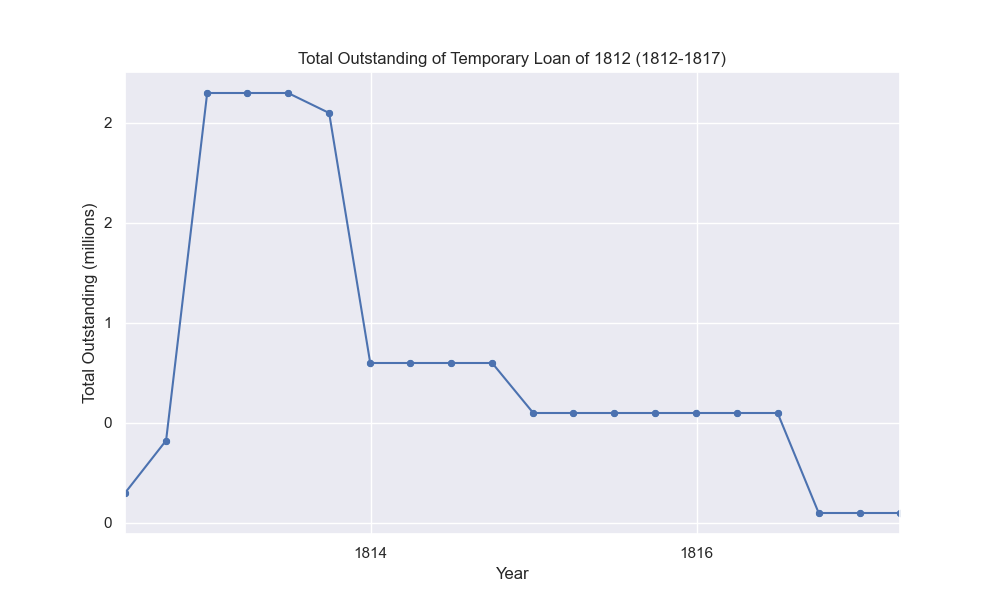

True


In [39]:
# temporary loan of 1812 
# prices - no price data 
"""
temp_loan_1812_prices = bond_price[bond_price["L1 ID"] == 20049] 
temp_loan_1812_prices_melted = melt_clean_price(temp_loan_1812_prices) # clean and melt (reformat) dataframe 
print(temp_loan_1812_prices_melted)
temp_loan_1812 = graph_price(temp_loan_1812_prices_melted, 'Market Price of Temporary Loan of 1812 (1813-1825)')
temp_loan_1812.show()
"""

# quantities 
temp_loan_1812_quant = bond_quant[bond_quant["L1 ID"] == 20049]
clean_temp_loan_1812_quant = clean_quant(temp_loan_1812_quant)
print(clean_six_percent_quant) 
total_outstanding = reformat_quant(clean_temp_loan_1812_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Temporary Loan of 1812 (1812-1817)", "mil") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_temp_loan_1812_quant, "Public Holdings")
#public_holdings.show()
print(public_holdings.equals(total_outstanding))

## Treasury Notes of 1812

### Overview and Features
1. Authorized By: <I>Act of June 30, 1812</i>
2. Why: Failure of the Six Percent Loan of 1812 to attract enough buyers
3. Detractors: Congressmen opposed the Treasury notes and wanted to use other revenue sources such as taxation. They argued banks and people scared of paper money would not purchase treasury notes because they weren't worth as much in gold or silver and that they would appreciate like the Continental Currency during the American Revolution.
5. No more than <b>\$ 5 million</b> could be issued.
6. Interest Rate: 5.4%
7. Frequency: At maturity
8. First Issue Denominations: \\$ 100, \$ 1000
9. 1-year loan (reimbursable 1 year from date)
10. Sold: at par

### Marketing
1. Versatility: Treasury notes would be used to pay off taxes, duties, and debts.
2. Convertible: Treasury notes could now be exchanged for long-term bonds paying 7 percent interest.
3. Supporters: Silver was in short supply and gold was undervalued. Therefore, coins could not be made. Treasury notes were seen as a good replacement for the First Bank of the US's notes. Depreciation would be avoided because notes could be used to pay off taxes and banks would keep them in their reserves. 

### Who Bought Them?
1. <b>$3.5 million</b> sold to banks, mostly located in Mid-Atlantic states.
2. By December 1, the remaining bills were sold off, many going to New England.
3. Report by Treasury Secretary Alexander Dallas (1814-1816) to Congress: Treasury notes were bought primarily by "necessitous creditors, or contractors in distress, or commissaries, quartermasters, and navy agents acting officially." 
4. Usage: Kagin cites the Niles Weekly Register, who observed how banks primarily used the treasury notes as reserves, meaning they were not circulating. In his report to Congress, Secretary Dallas states most notes went towards paying taxes.
#### Sources
- Dissertation
- Richard Bayley
- American Numismatic Association
- Monetary Aspects of the Treasury Notes of the War of 1812 by Donald H. Kagin 

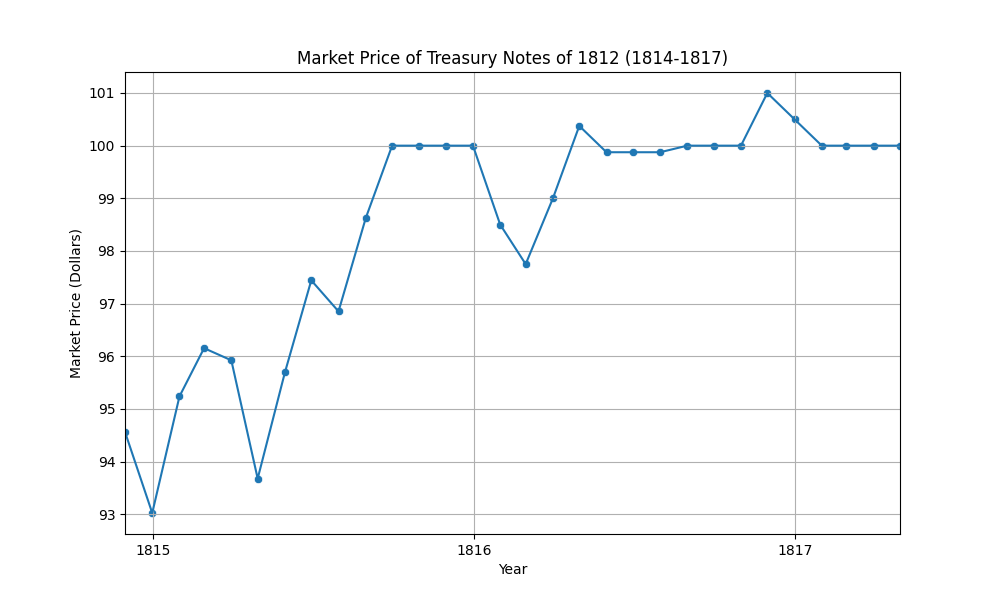

     L1 ID              Series  1812-12-31  1813-03-31  1813-06-30  \
248  20050  Active Outstanding   2835500.0   4752500.0   4792500.0   
251  20050     Public Holdings   2835500.0   4752500.0   4792500.0   
252  20050   Total Outstanding   2835500.0   4752500.0   4792500.0   

     1813-09-30  1813-12-31  1814-03-31  1814-06-30  1814-09-30  ...  \
248   4898300.0   5000000.0   5000000.0   2848800.0   2848800.0  ...   
251   4898300.0   5000000.0   5000000.0   2848800.0   2848800.0  ...   
252   4898300.0   5000000.0   5000000.0   2848800.0   2848800.0  ...   

     1834-09-30  1834-12-31  1835-03-31  1835-06-30  1835-09-30  1835-12-31  \
248       100.0       100.0       100.0       100.0       100.0       100.0   
251       100.0       100.0       100.0       100.0       100.0       100.0   
252       100.0       100.0       100.0       100.0       100.0       100.0   

     1836-03-31  1836-06-30  1836-09-30  1836-12-31  
248       100.0       100.0       100.0       100.0  
251  

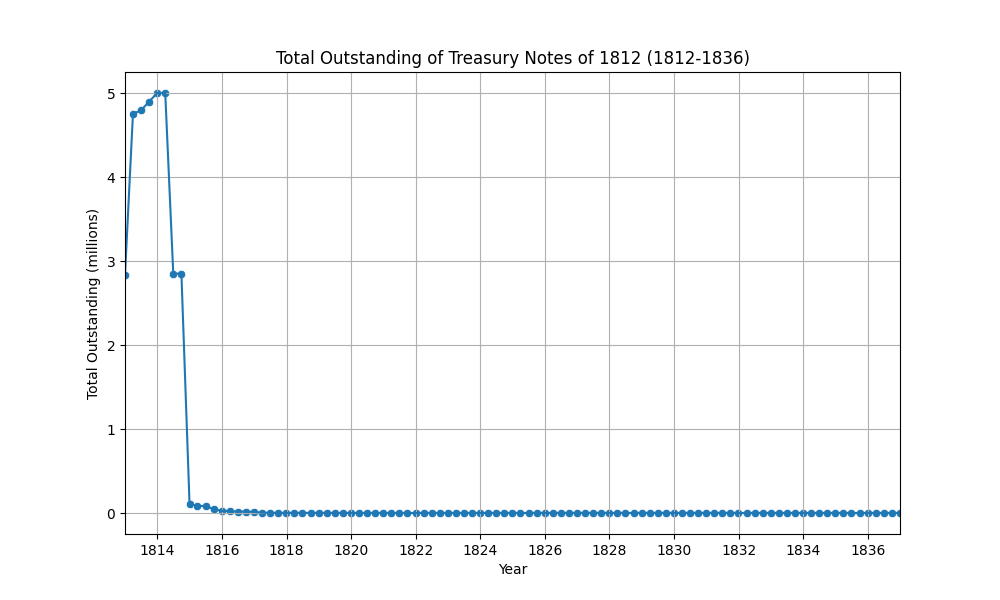

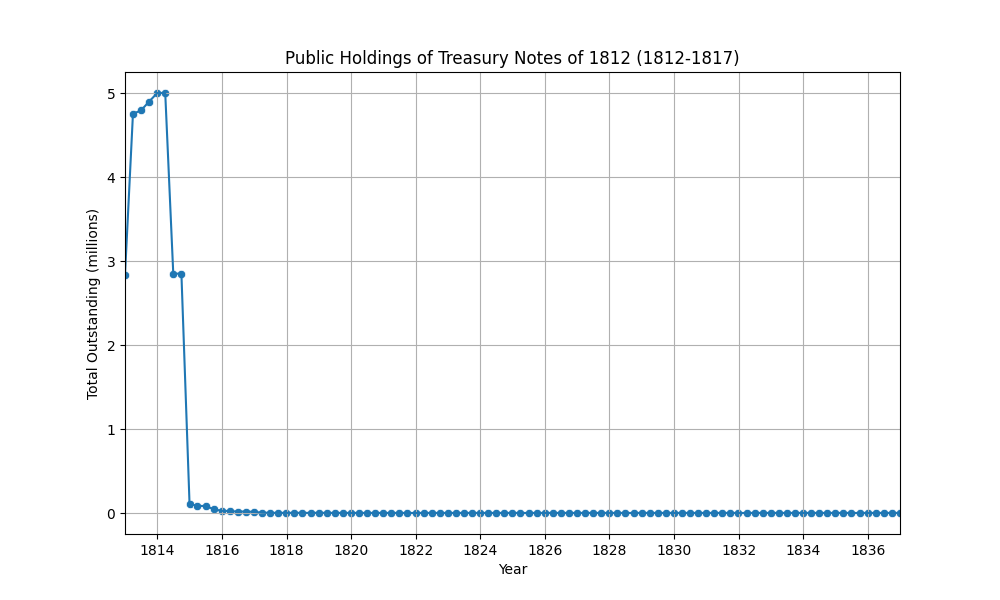

True


In [13]:
# treasury notes of 1812 prices 
treasure_notes_prices = bond_price[bond_price["L1 ID"] == 20050] 
treasure_notes_melted = melt_clean_price(treasure_notes_prices) # clean and melt (reformat) dataframe 
# print(treasure_notes_melted) 
treasure_notes = graph_price(treasure_notes_melted, 'Market Price of Treasury Notes of 1812 (1814-1817)')
treasure_notes.show()

# quantities 
treasure_notes_1812_quant = bond_quant[bond_quant["L1 ID"] == 20050]
clean_treasure_notes_1812_quant = clean_quant(treasure_notes_1812_quant)
# print(clean_treasure_notes_1812_quant) 
total_outstanding = reformat_quant(clean_treasure_notes_1812_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Treasury Notes of 1812 (1812-1836)", "mil") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_treasure_notes_1812_quant, "Public Holdings")
public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Treasury Notes of 1812 (1812-1817)", "mil") 
public_holdings_plot.show()
print(public_holdings.equals(total_outstanding))

## Exchanged Six Percent Stock

### Overview and Features
1. Authorized By: <I>An Act authorizing a subscription for the old six percent and deferred stocks, and providing an exchange for the same. </i>
2. What it did: Allowed individuals to reinvest in the old and deferred Six Percent stock in exchange for certificates, promising to pay back the principal amount. 
3. Interest rate: 6% 
### Marketing
### Who Bought Them?
#### Sources 

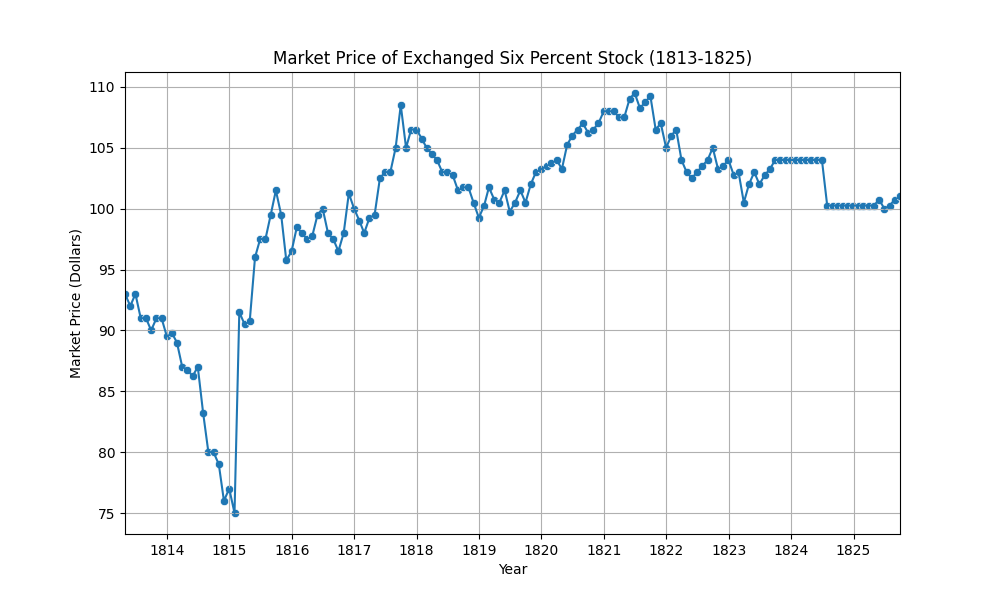

     L1 ID              Series  1812-12-31  1813-03-31  1813-06-30  \
253  20051  Active Outstanding  2745120.58  2984746.72  2984746.72   
256  20051     Public Holdings  2745120.58  2984746.72  2984746.72   
257  20051   Total Outstanding  2745120.58  2984746.72  2984746.72   

     1813-09-30  1813-12-31  1814-03-31  1814-06-30  1814-09-30  ...  \
253  2984746.72  2984746.72  2984746.72  2984746.72  2984746.72  ...   
256  2984746.72  2984746.72  2984746.72  2984746.72  2984746.72  ...   
257  2984746.72  2984746.72  2984746.72  2984746.72  2984746.72  ...   

     1824-09-30  1824-12-31  1825-03-31  1825-06-30  1825-09-30  1825-12-31  \
253  2668974.99  2668974.99   177650.18    55924.88    52210.62    16837.04   
256  2668974.99  2668974.99   177650.18    55924.88    52210.62    16837.04   
257  2668974.99  2668974.99   177650.18    55924.88    52210.62    16837.04   

     1826-03-31  1826-06-30  1826-09-30  1826-12-31  
253     8187.18     5491.05     5491.05     1477.08  
256  

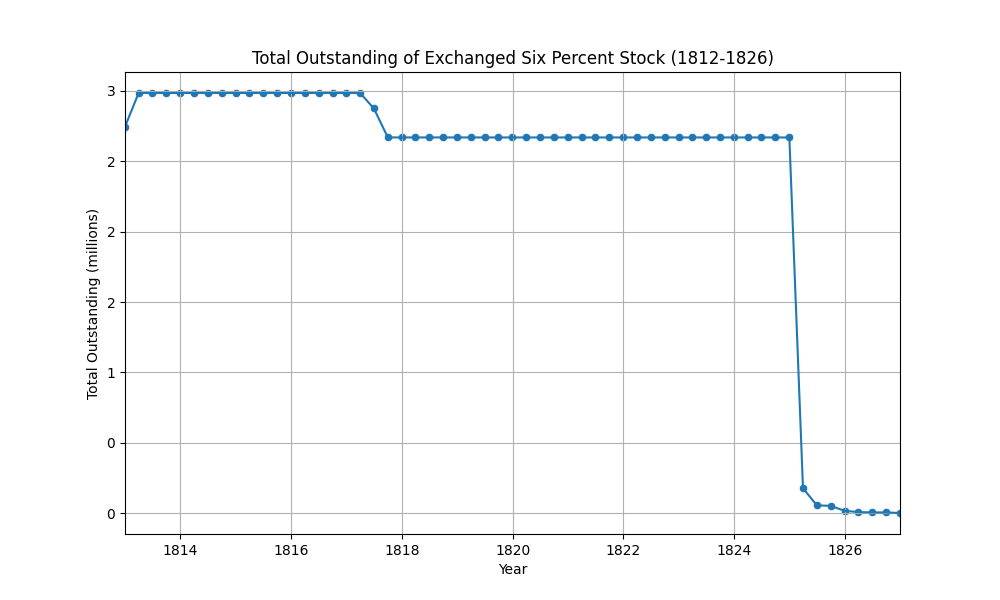

True


In [14]:
# Exchanged 6% stock 
exchanged_six_prices = bond_price[bond_price["L1 ID"] == 20051] 
exchanged_six_melted = melt_clean_price(exchanged_six_prices) # clean and melt (reformat) dataframe 
exchanged_six = graph_price(exchanged_six_melted, 'Market Price of Exchanged Six Percent Stock (1813-1825)') 
exchanged_six.show()

# quantities 
exchanged_six_quant = bond_quant[bond_quant["L1 ID"] == 20051]
clean_exchanged_six_quant = clean_quant(exchanged_six_quant)
print(clean_exchanged_six_quant) 
total_outstanding = reformat_quant(clean_exchanged_six_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Exchanged Six Percent Stock (1812-1826)", "mil") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_exchanged_six_quant, "Public Holdings")
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()
print(public_holdings.equals(total_outstanding))

## Sixteen Million Loan of 1813 

### Overview and Features
1. Authorized By: Act of February 8, 1813
2. Why: Treasury notes and import duties failed to cover war expenses. 
3. Authorized: \$ 16 million.
4. Interest Rate: 6%
5. Frequency: Quarterly
6. Redeemable: January 1, 1826 
7. Commissions: 1/4th of 1% for agents
8. Sold: 88 percent face value
9. Issued: \\$ 18,109,377.43 (\\$ 2,109,377.43 due to discount + the authorized \$ 16 million)

### Marketing
1. Context: Banking institutions did not buy the bonds. Potential buyers were scared by America losing the war. By March, the loan had a shortfall of \$ 10 million. Therefore, Gallatin began relying on wealthy individuals to make up for the deficit. 
2. Stephen Girard: French native; banker and financier; operated a private bank in Philadelphia; private letters reveal focus on profit; friends with Secretary Gallatin; agreed to help make up for the \$ 10 million shortfall; his decision increased public confidence; personal share: \$ 2,483,000 
3. David Parish:
4. John Jacob Astor:

#### Sources
- Dissertation
- Girard to the Rescue: Stephen Girard and the War Loan of February 8, 1813 by Mark T. Hensen

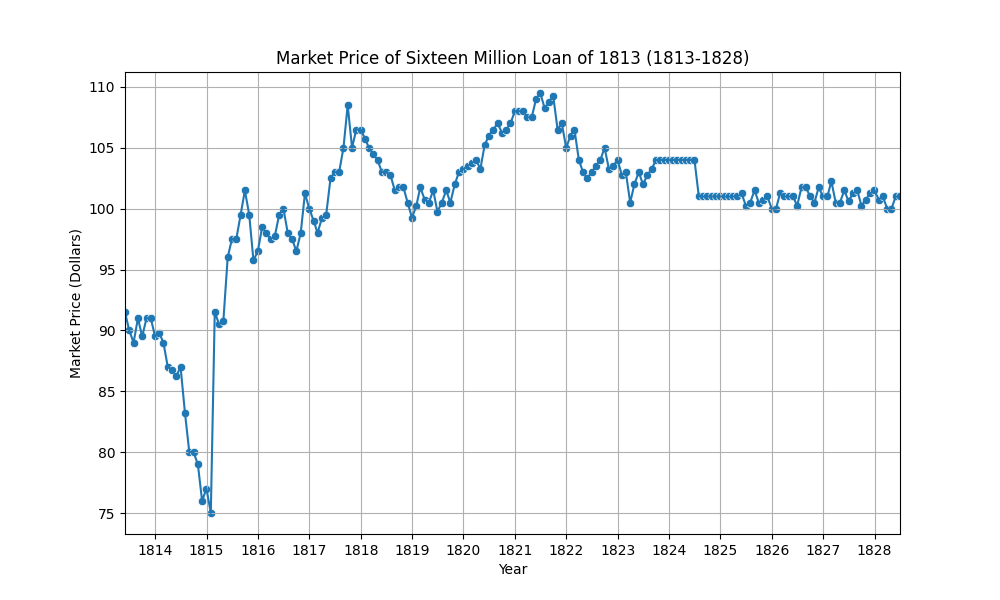

     L1 ID              Series  1813-03-31  1813-06-30  1813-09-30  \
258  20052  Active Outstanding   1086737.5  11352012.5  14488125.0   
261  20052     Public Holdings   1086737.5  11352012.5  14488125.0   
262  20052   Total Outstanding   1086737.5  11352012.5  14488125.0   

      1813-12-31   1814-03-31   1814-06-30   1814-09-30   1814-12-31  ...  \
258  18109377.43  18109377.43  18109377.43  18109377.43  18109377.43  ...   
261  18109377.43  18109377.43  18109377.43  18109377.43  18109377.43  ...   
262  18109377.43  18109377.43  18109377.43  18109377.43  18109377.43  ...   

     1837-09-30  1837-12-31  1838-03-31  1838-06-30  1838-09-30  1838-12-31  \
258     5546.39     5546.39     5546.39     5546.39     5546.39     5546.39   
261     5546.39     5546.39     5546.39     5546.39     5546.39     5546.39   
262     5546.39     5546.39     5546.39     5546.39     5546.39     5546.39   

     1839-03-31  1839-06-30  1839-09-30  1839-12-31  
258     5546.39     5546.39     5546.39

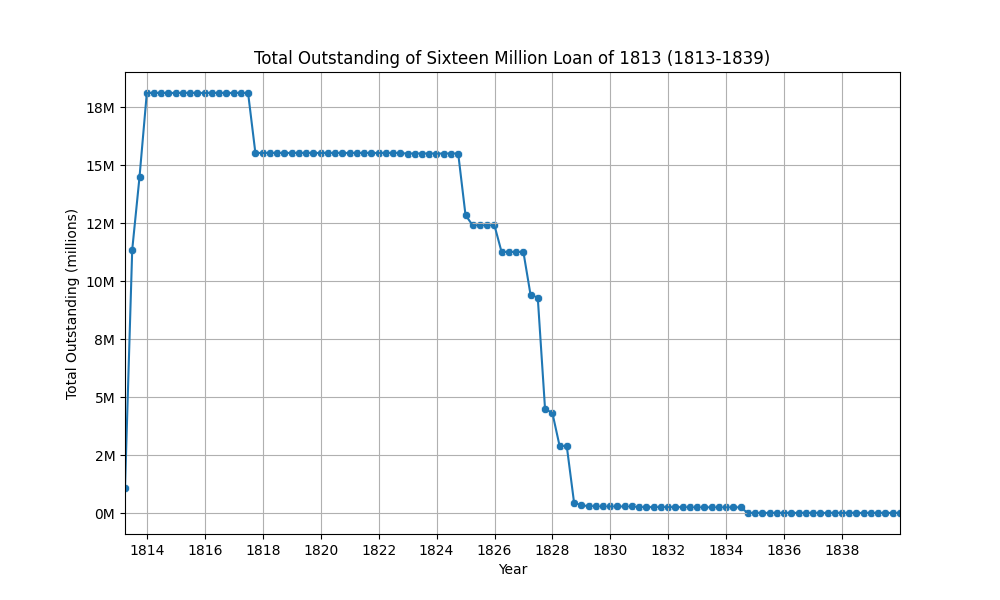

True


In [11]:
# Sixteen million loan of 1813 
sixteen_mil_prices = bond_price[bond_price["L1 ID"] == 20052] 
sixteen_mil_melted = melt_clean_price(sixteen_mil_prices) # clean and melt (reformat) dataframe 
sixteen_mil = graph_price(sixteen_mil_melted, 'Market Price of Sixteen Million Loan of 1813 (1813-1828)') 
sixteen_mil.show()

# quantities 
sixteen_mil_quant = bond_quant[bond_quant["L1 ID"] == 20052]
clean_sixteen_mil_quant = clean_quant(sixteen_mil_quant)
print(clean_sixteen_mil_quant) 
total_outstanding = reformat_quant(clean_sixteen_mil_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Sixteen Million Loan of 1813 (1813-1839)") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_sixteen_mil_quant, "Public Holdings")
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()
print(public_holdings.equals(total_outstanding))

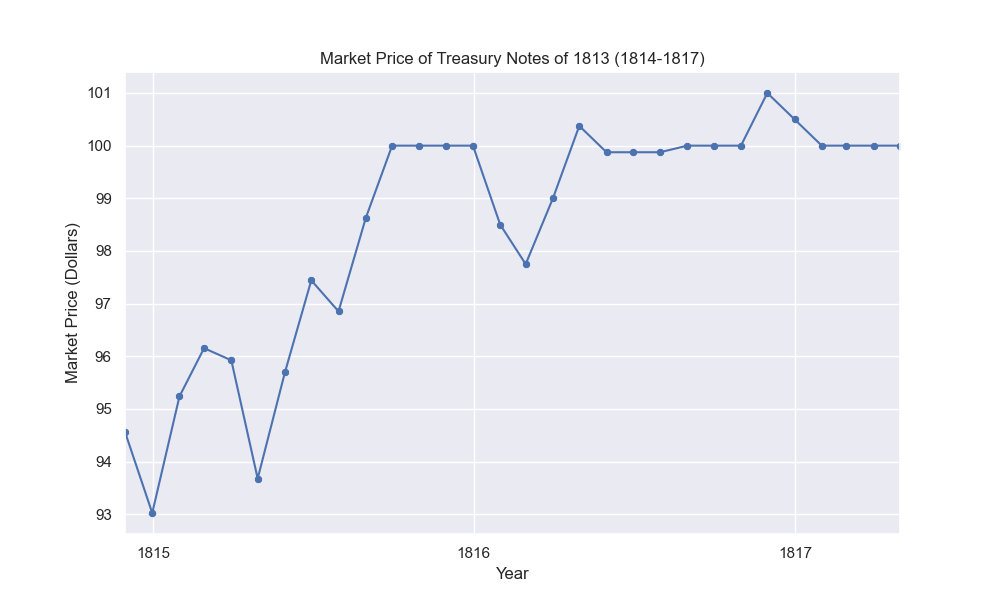

     L1 ID              Series  1813-03-31  1813-06-30  1813-09-30  \
263  20053  Active Outstanding     32000.0    253000.0    253000.0   
266  20053     Public Holdings     32000.0    253000.0    253000.0   
267  20053   Total Outstanding     32000.0    253000.0    253000.0   

     1813-12-31  1814-03-31  1814-06-30  1814-09-30  1814-12-31  ...  \
263   3930000.0   5000000.0   4800000.0   4800000.0   4053100.0  ...   
266   3930000.0   5000000.0   4800000.0   4800000.0   4053100.0  ...   
267   3930000.0   5000000.0   4800000.0   4800000.0   4053100.0  ...   

     1834-09-30  1834-12-31  1835-03-31  1835-06-30  1835-09-30  1835-12-31  \
263       900.0       900.0       900.0       900.0       900.0       900.0   
266       900.0       900.0       900.0       900.0       900.0       900.0   
267       900.0       900.0       900.0       900.0       900.0       900.0   

     1836-03-31  1836-06-30  1836-09-30  1836-12-31  
263       900.0       900.0       900.0       900.0  
266  

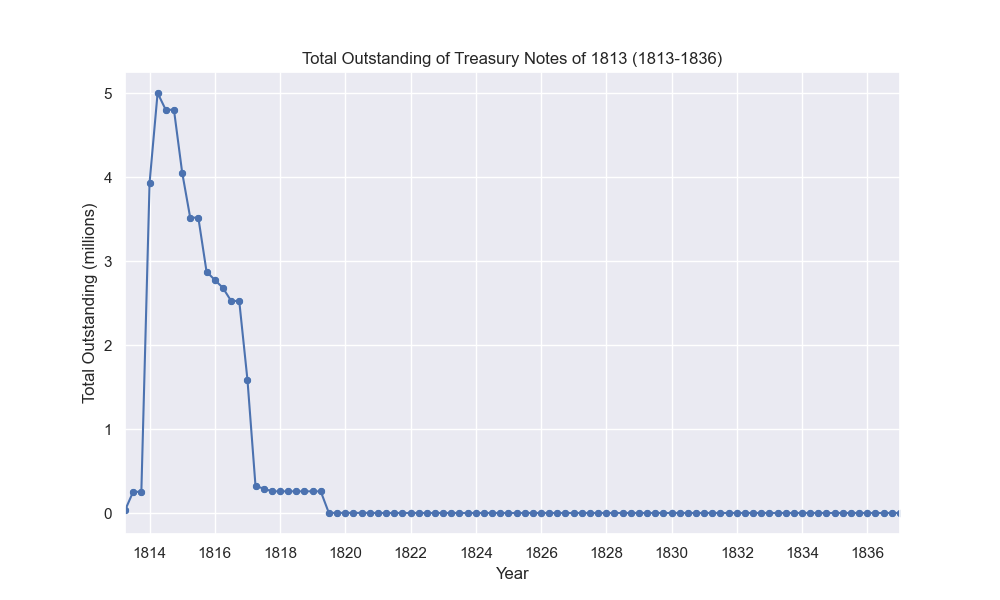

True


In [43]:
# Treasury Notes of 1813 
treasury_notes_1813_prices = bond_price[bond_price["L1 ID"] == 20053] 
treasury_notes_1813_melted = melt_clean_price(treasury_notes_1813_prices) # clean and melt (reformat) dataframe 
treasury_notes_1813 = graph_price(treasury_notes_1813_melted, 'Market Price of Treasury Notes of 1813 (1814-1817)') 
treasury_notes_1813.show()

# quantities 
treasury_notes_1813_quant = bond_quant[bond_quant["L1 ID"] == 20053]
clean_treasury_notes_1813_quant = clean_quant(treasury_notes_1813_quant)
print(clean_treasury_notes_1813_quant) 
total_outstanding = reformat_quant(clean_treasury_notes_1813_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Treasury Notes of 1813 (1813-1836)", "mil") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_treasury_notes_1813_quant, "Public Holdings")
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()
print(public_holdings.equals(total_outstanding))

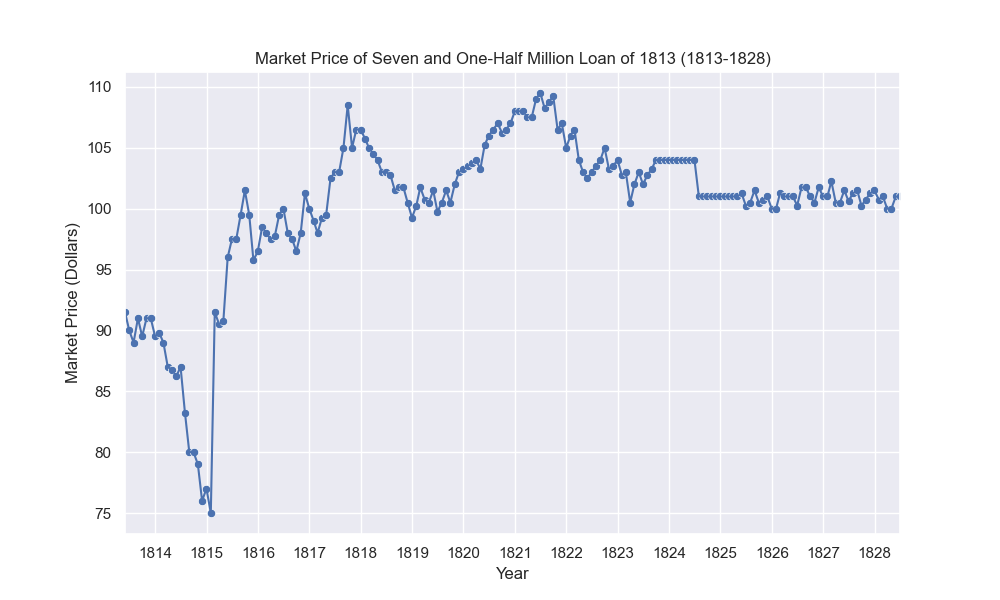

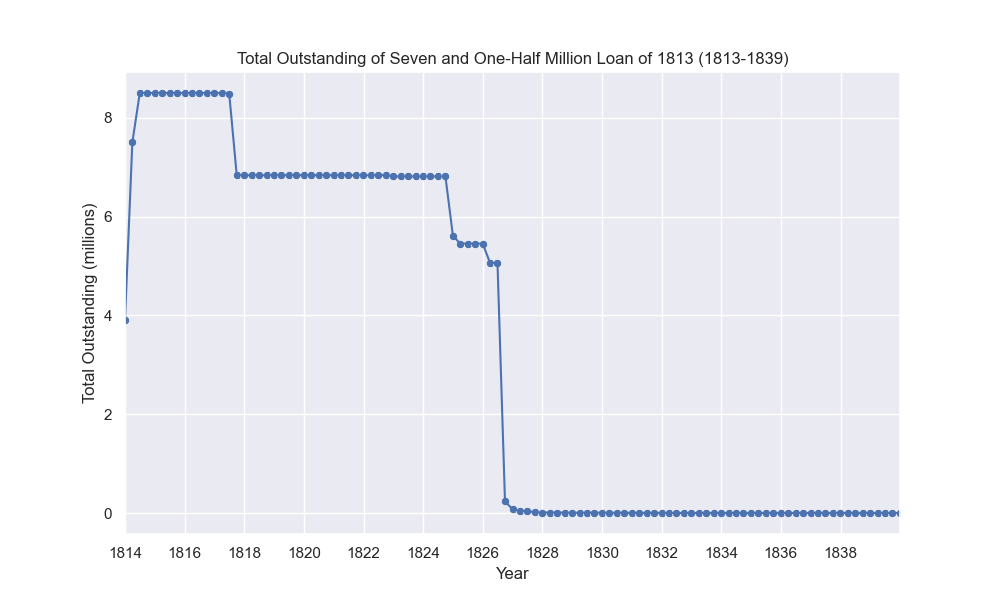

True


In [44]:
# seven and one-half million loan of 1813 
seven_one_half_prices = bond_price[bond_price["L1 ID"] == 20054] 
seven_one_half_melted = melt_clean_price(seven_one_half_prices) # clean and melt (reformat) dataframe 
seven_one_half = graph_price(seven_one_half_melted, 'Market Price of Seven and One-Half Million Loan of 1813 (1813-1828)') 
seven_one_half.show()

# quantities 
seven_one_half_quant = bond_quant[bond_quant["L1 ID"] == 20054]
clean_seven_one_half_quant = clean_quant(seven_one_half_quant)
#print(clean_seven_one_half_quant) 
total_outstanding = reformat_quant(clean_seven_one_half_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Seven and One-Half Million Loan of 1813 (1813-1839)", "mil") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_seven_one_half_quant, "Public Holdings")
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()
print(public_holdings.equals(total_outstanding))

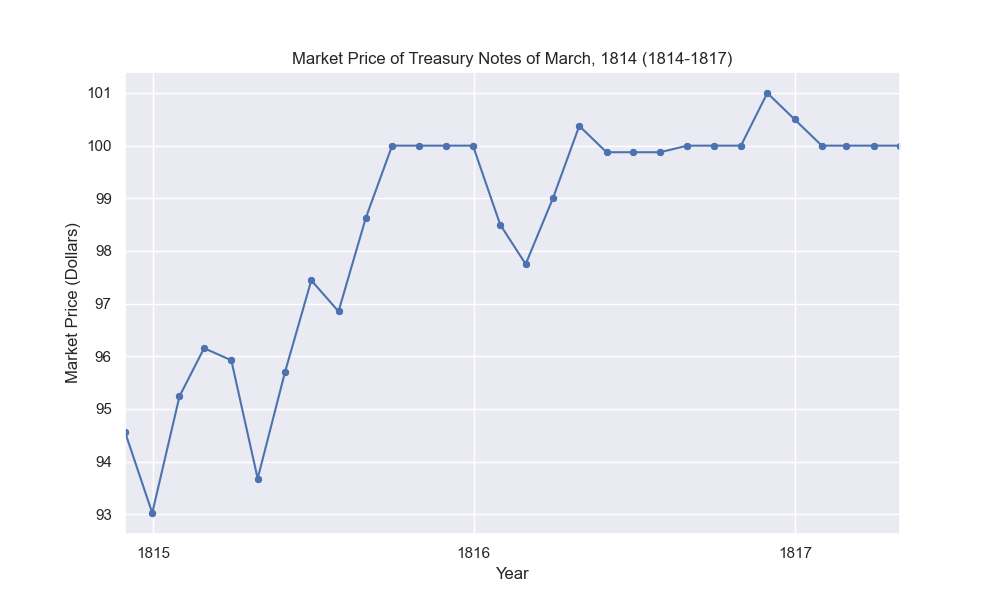

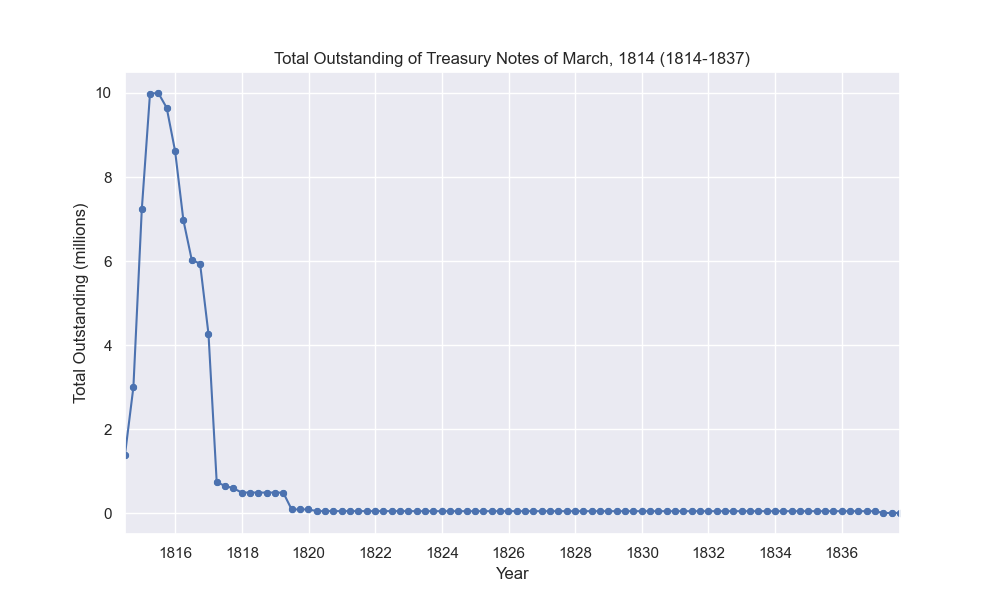

True


In [45]:
# treasury notes of March, 1814
notes_1814_prices = bond_price[bond_price["L1 ID"] == 20055] 
notes_1814_melted = melt_clean_price(notes_1814_prices) # clean and melt (reformat) dataframe 
notes_1814 = graph_price(notes_1814_melted, "Market Price of Treasury Notes of March, 1814 (1814-1817)")  
notes_1814.show()

# quantities 
notes_1814_quant = bond_quant[bond_quant["L1 ID"] == 20055]
clean_notes_1814_quant = clean_quant(notes_1814_quant)
#print(clean_seven_one_half_quant) 
total_outstanding = reformat_quant(clean_notes_1814_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Treasury Notes of March, 1814 (1814-1837)", "mil") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_notes_1814_quant, "Public Holdings")
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()
print(public_holdings.equals(total_outstanding))

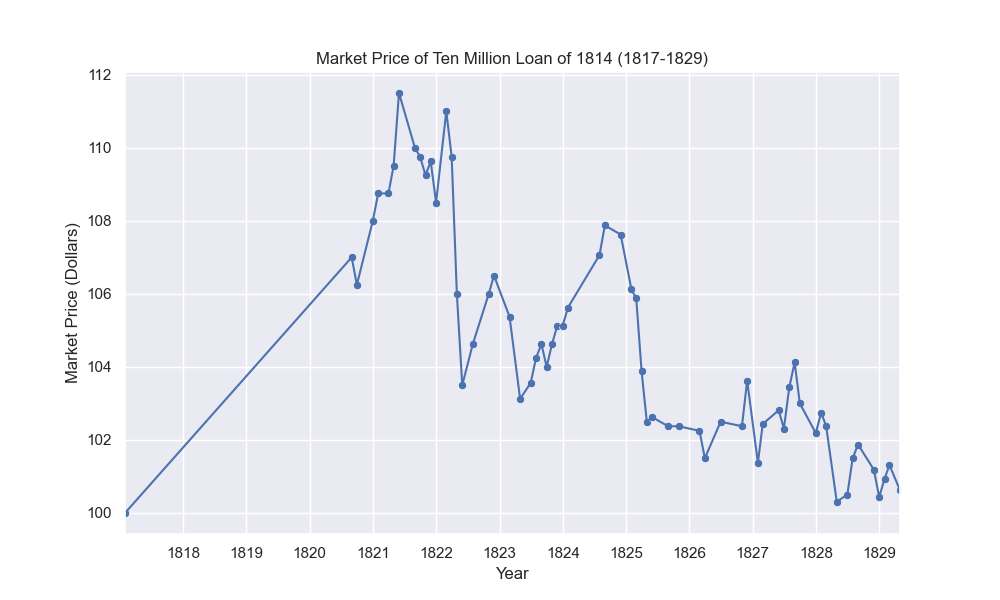

     L1 ID              Series  1814-06-30  1814-09-30  1814-12-31  \
278  20056  Active Outstanding   6087011.0   7935141.0  9919476.25   
281  20056     Public Holdings   6087011.0   7935141.0  9919476.25   
282  20056   Total Outstanding   6087011.0   7935141.0  9919476.25   

     1815-03-31  1815-06-30  1815-09-30  1815-12-31  1816-03-31  ...  \
278  9919476.25  9919476.25  9919476.25  9919476.25  9919476.25  ...   
281  9919476.25  9919476.25  9919476.25  9919476.25  9919476.25  ...   
282  9919476.25  9919476.25  9919476.25  9919476.25  9919476.25  ...   

     1837-09-30  1837-12-31  1838-03-31  1838-06-30  1838-09-30  1838-12-31  \
278      708.98      708.98      708.98      708.98      708.98      708.98   
281      708.98      708.98      708.98      708.98      708.98      708.98   
282      708.98      708.98      708.98      708.98      708.98      708.98   

     1839-03-31  1839-06-30  1839-09-30  1839-12-31  
278      708.98      708.98      708.98      708.98  
281  

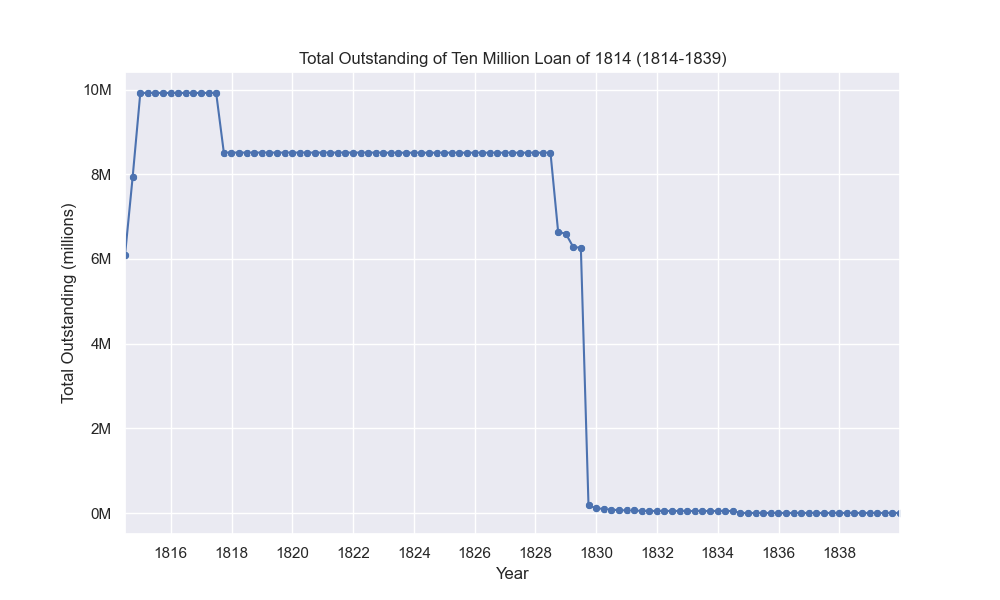

True


In [25]:
# 10 mil loan of 1814 
ten_mil_prices = bond_price[bond_price["L1 ID"] == 20056] 
ten_mil_melted = melt_clean_price(ten_mil_prices) # clean and melt (reformat) dataframe 
ten_mil = graph_price(ten_mil_melted, "Market Price of Ten Million Loan of 1814 (1817-1829)")  
ten_mil.show()

# quantities 
ten_mil_quant = bond_quant[bond_quant["L1 ID"] == 20056]
clean_ten_mil_quant = clean_quant(ten_mil_quant)
print(clean_ten_mil_quant) 
total_outstanding = reformat_quant(clean_ten_mil_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Ten Million Loan of 1814 (1814-1839)") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_ten_mil_quant, "Public Holdings")
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()
print(public_holdings.equals(total_outstanding))

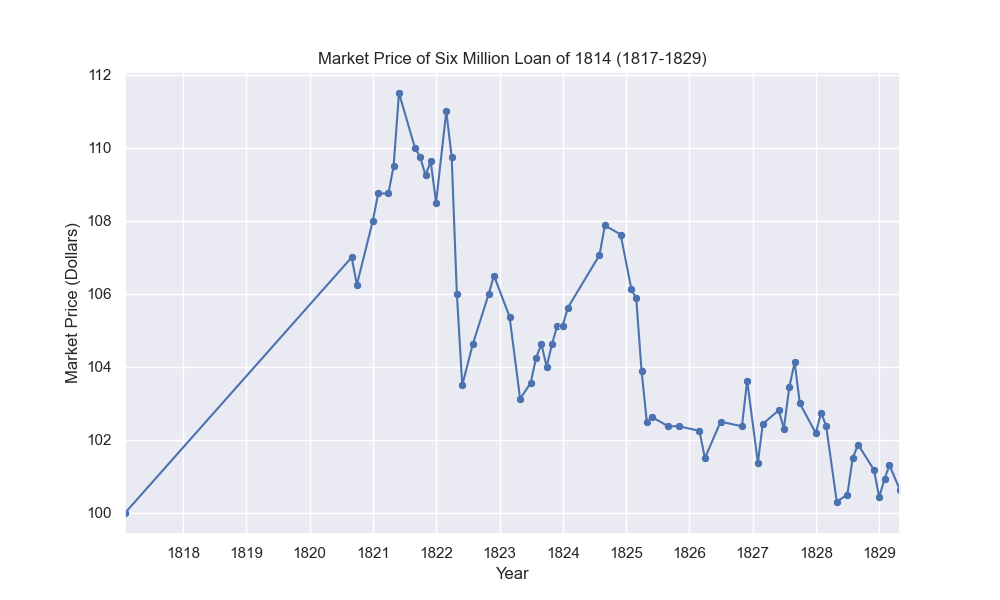

     L1 ID              Series  1814-06-30  1814-09-30  1814-12-31  \
278  20056  Active Outstanding   6087011.0   7935141.0  9919476.25   
281  20056     Public Holdings   6087011.0   7935141.0  9919476.25   
282  20056   Total Outstanding   6087011.0   7935141.0  9919476.25   

     1815-03-31  1815-06-30  1815-09-30  1815-12-31  1816-03-31  ...  \
278  9919476.25  9919476.25  9919476.25  9919476.25  9919476.25  ...   
281  9919476.25  9919476.25  9919476.25  9919476.25  9919476.25  ...   
282  9919476.25  9919476.25  9919476.25  9919476.25  9919476.25  ...   

     1837-09-30  1837-12-31  1838-03-31  1838-06-30  1838-09-30  1838-12-31  \
278      708.98      708.98      708.98      708.98      708.98      708.98   
281      708.98      708.98      708.98      708.98      708.98      708.98   
282      708.98      708.98      708.98      708.98      708.98      708.98   

     1839-03-31  1839-06-30  1839-09-30  1839-12-31  
278      708.98      708.98      708.98      708.98  
281  

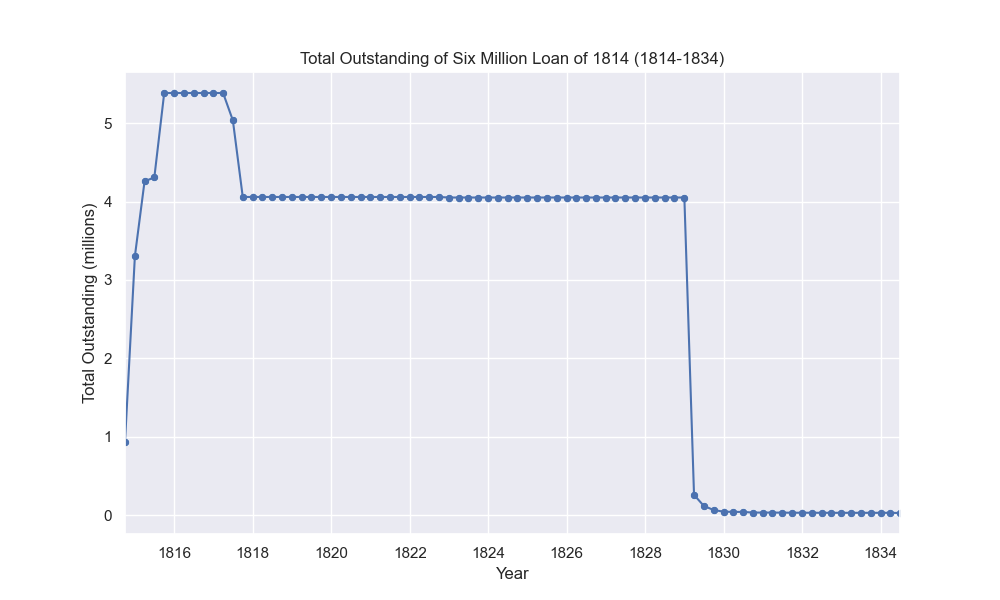

True


In [46]:
# Six Million Loan of 1814 
six_mil_1814_prices = bond_price[bond_price["L1 ID"] == 20057] 
six_mil_1814_melted = melt_clean_price(six_mil_1814_prices) # clean and melt (reformat) dataframe 
six_mil_1814 = graph_price(six_mil_1814_melted, "Market Price of Six Million Loan of 1814 (1817-1829)")  
six_mil_1814.show()

# quantities 
six_mil_1814_quant = bond_quant[bond_quant["L1 ID"] == 20057]
clean_six_mil_1814_quant = clean_quant(six_mil_1814_quant)
print(clean_ten_mil_quant) 
total_outstanding = reformat_quant(clean_six_mil_1814_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Six Million Loan of 1814 (1814-1834)", "mil") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_six_mil_1814_quant, "Public Holdings")
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()
print(public_holdings.equals(total_outstanding))

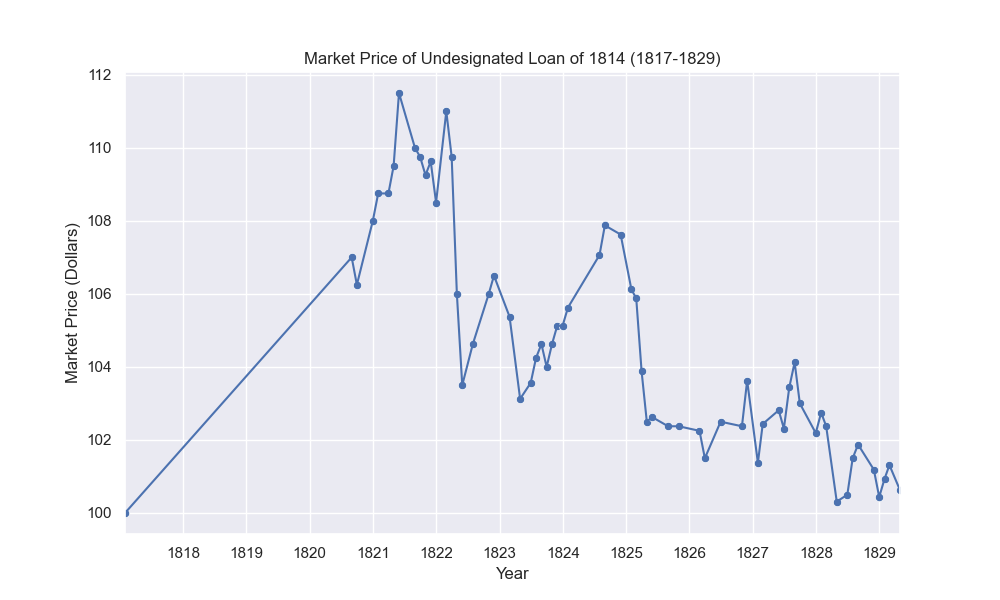

     L1 ID              Series  1814-12-31  1815-03-31  1815-06-30  \
288  20058  Active Outstanding    150000.0   334032.22   408622.97   
291  20058     Public Holdings    150000.0   334032.22   408622.97   
292  20058   Total Outstanding    150000.0   334032.22   408622.97   

     1815-09-30  1815-12-31  1816-03-31  1816-06-30  1816-09-30  ...  \
288   408622.97   408622.97   572534.36   652534.36   746403.31  ...   
291   408622.97   408622.97   572534.36   652534.36   746403.31  ...   
292   408622.97   408622.97   572534.36   652534.36   746403.31  ...   

     1832-03-31  1832-06-30  1832-09-30  1832-12-31  1833-03-31  1833-06-30  \
288     1760.91     1760.91     1760.91     1760.91     1760.91     1760.91   
291     1760.91     1760.91     1760.91     1760.91     1760.91     1760.91   
292     1760.91     1760.91     1760.91     1760.91     1760.91     1760.91   

     1833-09-30  1833-12-31  1834-03-31  1834-06-30  
288     1760.91     1760.91     1760.91     1760.91  
291  

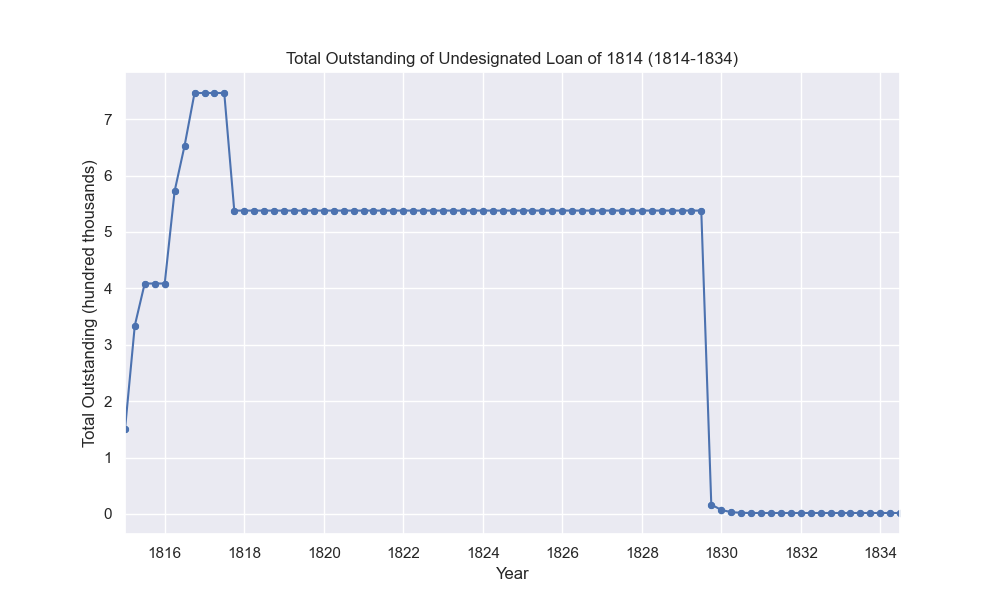

True


In [37]:
# Undesignated Loan of 1814
undesignated_1814_prices = bond_price[bond_price["L1 ID"] == 20058] 
undesignated_1814_melted = melt_clean_price(undesignated_1814_prices) # clean and melt (reformat) dataframe 
undesignated_1814 = graph_price(undesignated_1814_melted, "Market Price of Undesignated Loan of 1814 (1817-1829)")  
undesignated_1814.show()

# quantities 
undesignated_1814_quant = bond_quant[bond_quant["L1 ID"] == 20058]
clean_undesignated_1814_quant = clean_quant(undesignated_1814_quant)
print(clean_undesignated_1814_quant) 
total_outstanding = reformat_quant(clean_undesignated_1814_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Undesignated Loan of 1814 (1814-1834)", "ht") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_undesignated_1814_quant, "Public Holdings")
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()
print(public_holdings.equals(total_outstanding))

    Timestamp      Quant
0  1814-12-31   150000.0
1  1815-03-31  334032.22
2  1815-06-30  408622.97
3  1815-09-30  408622.97
4  1815-12-31  408622.97
..        ...        ...
74 1833-06-30    1760.91
75 1833-09-30    1760.91
76 1833-12-31    1760.91
77 1834-03-31    1760.91
78 1834-06-30    1760.91

[79 rows x 2 columns]


/var/folders/ct/jjmfnk013tn1r7zs75r9b1gw0000gn/T/ipykernel_77916/463614340.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


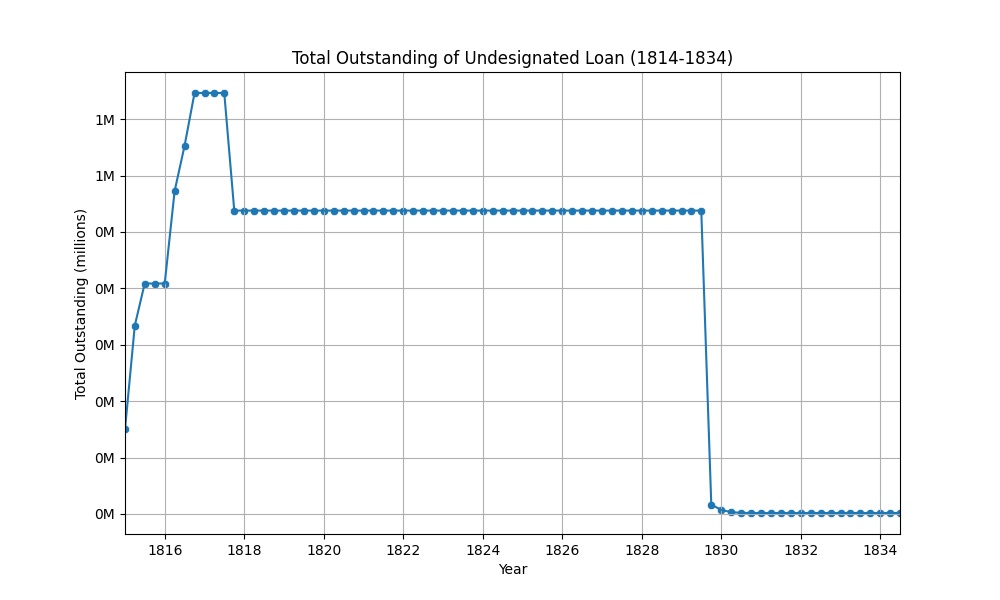

'\n# Bond quantities \nactive_outstanding = clean_six_percent_quant[clean_six_percent_quant["Series"] == "Active Outstanding"].melt(var_name=\'Timestamp\', value_name=\'Quant\')\nactive_outstanding = active_outstanding.iloc[2:].reset_index(drop=True)\nprint(active_outstanding)\n\npublic_holdings = clean_six_percent_quant[clean_six_percent_quant["Series"] == "Public Holdings"].melt(var_name=\'Timestamp\', value_name=\'Quant\')\npublic_holdings = public_holdings.iloc[2:].reset_index(drop=True)\nprint(public_holdings)\n\ntotal_outstanding = clean_six_percent_quant[clean_six_percent_quant["Series"] == "Total Outstanding"].melt(var_name=\'Timestamp\', value_name=\'Quant\')\ntotal_outstanding = total_outstanding.iloc[2:].reset_index(drop=True)\nprint(total_outstanding)\n'

In [18]:
undesignated_1814_quant = bond_quant[bond_quant["L1 ID"] == 20058]
clean_undesignated_1814_quant = clean_quant(undesignated_1814_quant)
#print(clean_undesignated_1814_quant) 
total_outstanding = reformat_quant(clean_undesignated_1814_quant, "Total Outstanding")
print(total_outstanding)
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Undesignated Loan (1814-1834)") 
total_outstanding_plot.show()

#public_holdings = reformat_quant(clean_undesignated_1814_quant, "Public Holdings")
#public_holdings.show()
#print(public_holdings)
#print(public_holdings.equals(total_outstanding))
"""
# Bond quantities 
active_outstanding = clean_six_percent_quant[clean_six_percent_quant["Series"] == "Active Outstanding"].melt(var_name='Timestamp', value_name='Quant')
active_outstanding = active_outstanding.iloc[2:].reset_index(drop=True)
print(active_outstanding)

public_holdings = clean_six_percent_quant[clean_six_percent_quant["Series"] == "Public Holdings"].melt(var_name='Timestamp', value_name='Quant')
public_holdings = public_holdings.iloc[2:].reset_index(drop=True)
print(public_holdings)

total_outstanding = clean_six_percent_quant[clean_six_percent_quant["Series"] == "Total Outstanding"].melt(var_name='Timestamp', value_name='Quant')
total_outstanding = total_outstanding.iloc[2:].reset_index(drop=True)
print(total_outstanding)
""" 